<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [1]:
!pip install transformers
#phi-hung_andre@outlook.fr
import platform; platform.mac_ver()
import platform; platform.mac_ver()
platform.platform()


zsh:1: command not found: pip


'macOS-13.0-arm64-arm-64bit'

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("mps")
torch.backends.mps.is_available()


/Users/harry/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/harry/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/harry/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


True

# Load Dataset

In [3]:
dictionary = pd.read_csv("./sst_dataset/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/dictionary.txt", sep="|", index_col=1, header=None)

label = pd.read_csv("./sst_dataset/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/sentiment_labels.txt", sep="|", index_col=0)
dictionary = dictionary.sort_index()
df = pd.merge(dictionary, label, left_index=True, right_index=True)
df.head()

0  sentiment values
1                                       
0                    !           0.50000
1                    '           0.50000
2                  ' (           0.44444
3    ' ( the cockettes           0.50000
4  ' ( the cockettes )           0.42708

In [4]:
df.shape

(239232, 2)

In [5]:
# check class distribution
df = df.reset_index()
df = df.rename(columns={ 0:'text', 'sentiment values':'label'})
df = df.drop(1, axis=1)
df = df[['label', 'text']]
df['label'].value_counts(normalize = True)

label
0.50000    0.189072
0.55556    0.037064
0.44444    0.033804
0.51389    0.029369
0.61111    0.026180
             ...   
0.59028    0.000004
0.40625    0.000004
0.45139    0.000004
0.17708    0.000004
0.38194    0.000004
Name: proportion, Length: 142, dtype: float64

# Split train dataset into train, validation and test sets

In [6]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                               random_state=2018, 
                                                               test_size=0.5)

# Import BERT Model and BERT Tokenizer

In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', return_dict=False)

/Users/harry/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [8]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [9]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

['another silly Hollywood action film , one among a multitude of simple-minded ,',
 'make a classic theater piece',
 'of veteran painters',
 'many inconsistencies',
 'its second',
 "you 've seen the remake first . Many of the effective horror elements are dampened through familiarity , ( yet )",
 'spry 2001',
 'tough enough to fit in any modern action movie',
 'its most famous previous film adaptation',
 'in a fantasy world',
 'most daring ,',
 'The Sum of All Fears is almost impossible to follow',
 'repulsive and depressing',
 'for great cinema',
 'constructs',
 'The unique tug-of-war with viewer expectations',
 'even the claustrophobic on-board quarters seem fun .',
 'more frustrating than a modem that disconnects every 10 seconds',
 "The enjoyable Undercover Brother , a zany mix of Saturday Night Live-style parody , '70s Blaxploitation films and goofball action comedy gone wild",
 'exceeding',
 'recalls the classics of early Italian neorealism',
 "sets it apart is the vision that ta

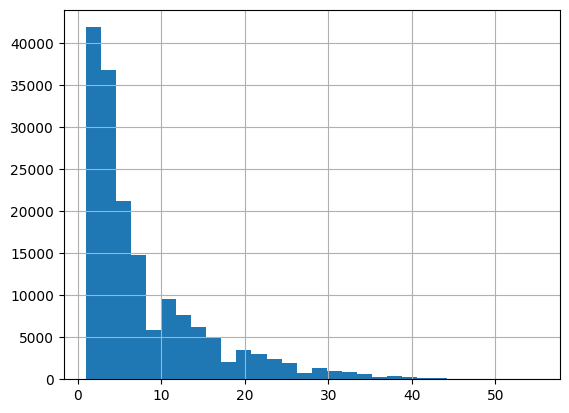

In [10]:
# get length of all the messages in the train set
seq_len = [len(str(i).split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
train_text.tolist()
res = []
for i in train_text.tolist():
    i = str(i)
    i = i.replace('"', '\'')
    res.append(i)
res

In [11]:
max_seq_len = 50
type(train_text.tolist())
print(train_text.tolist())
torch.cuda.is_available()


['another silly Hollywood action film , one among a multitude of simple-minded ,', 'make a classic theater piece', 'of veteran painters', 'many inconsistencies', 'its second', "you 've seen the remake first . Many of the effective horror elements are dampened through familiarity , ( yet )", 'spry 2001', 'tough enough to fit in any modern action movie', 'its most famous previous film adaptation', 'in a fantasy world', 'most daring ,', 'The Sum of All Fears is almost impossible to follow', 'repulsive and depressing', 'for great cinema', 'constructs', 'The unique tug-of-war with viewer expectations', 'even the claustrophobic on-board quarters seem fun .', 'more frustrating than a modem that disconnects every 10 seconds', "The enjoyable Undercover Brother , a zany mix of Saturday Night Live-style parody , '70s Blaxploitation films and goofball action comedy gone wild", 'exceeding', 'recalls the classics of early Italian neorealism', "sets it apart is the vision that taymor , the avant gard

False

In [12]:
# tokenize and encode sequences in the training set

tokens_train = tokenizer(
    res,
    padding="max_length", 
    truncation=True)
   

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/Users/harry/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [13]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
print('don00e')

don00e


# Create DataLoaders

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)



print('d000one')

d000one


# Freeze BERT Parameters

In [15]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [16]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,131)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

In [18]:
from transformers import AdamW
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Find Class Weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np 
#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes =np.unique(train_labels), y=train_labels)

print(class_wts.shape)

(131,)


In [20]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [21]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [22]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  # empty list to save the model predictions
  total_preds = []
  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [23]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  5,234.
  Batch   100  of  5,234.
  Batch   150  of  5,234.
  Batch   200  of  5,234.
  Batch   250  of  5,234.
  Batch   300  of  5,234.
  Batch   350  of  5,234.
  Batch   400  of  5,234.
  Batch   450  of  5,234.
  Batch   500  of  5,234.
  Batch   550  of  5,234.
  Batch   600  of  5,234.
  Batch   650  of  5,234.
  Batch   700  of  5,234.
  Batch   750  of  5,234.
  Batch   800  of  5,234.
  Batch   850  of  5,234.
  Batch   900  of  5,234.
  Batch   950  of  5,234.
  Batch 1,000  of  5,234.
  Batch 1,050  of  5,234.
  Batch 1,100  of  5,234.
  Batch 1,150  of  5,234.
  Batch 1,200  of  5,234.
  Batch 1,250  of  5,234.
  Batch 1,300  of  5,234.
  Batch 1,350  of  5,234.
  Batch 1,400  of  5,234.
  Batch 1,450  of  5,234.
  Batch 1,500  of  5,234.
  Batch 1,550  of  5,234.
  Batch 1,600  of  5,234.
  Batch 1,650  of  5,234.
  Batch 1,700  of  5,234.
  Batch 1,750  of  5,234.
  Batch 1,800  of  5,234.
  Batch 1,850  of  5,234.
  Batch 1,900  of  5,23

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

def evaluate_test():
  
  print("\nEvaluating test...")
  
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  # empty list to save the model predictions
  total_preds = []
  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds 

def data_to_bins(df,target_column):
  bins = [0, 10, 15, 20, 25, 30, np.inf]
  labels = bins[1:]
  return df["labeled_bins"] = pd.cut(df["target_column"], bins=bins, labels=False)


evaluate_test()
#with torch.no_grad():
#  preds = model(test_seq.to(device), test_mask.to(device))
#      batch = [r.to(device) for r in batch]

#  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)